# ResNet 구현


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
np.random.seed(7777)
tf.random.set_seed(7777)

### ResNet

![](../script_imgs/resnet.png)

### ResNet의 핵심은 Skip Connection

![](../script_imgs/skipconnection.png)

- 인풋을 아웃풋과 더해서 전달!
- x를 기억(어딘가에 저장) 해놨다가 내보낼때 더해야하는데 Sequatial 방식으론 한계

### 2. Functional API 

`tf.keras.Sequential` 보다 더 유연하게 모델을 정의할 수 있는 방법

In [3]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

In [4]:
## Functional API 를 이용해 ResNet 구현

def build_resnet(input_shape):
    inputs = Input(input_shape)

    net = Conv2D(32, kernel_size=3, strides=2,
                 padding='same', activation='relu')(inputs)
    net = MaxPool2D()(net)
    # 여기까지 ex) 28x28 -> 14x14 -> 7x7 이 됨? padding same 인데???
    
    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)
    
    # Resnet의 핵심 input과 output을 더해서 전달!
    # net + net3 하려는데 차원이 다르다! net을 64로 늘려 1_1로 반환받아 더하자
    # 더해서 다시 위와 같은 구조 반복
    net1_1 = Conv2D(64, kernel_size=1, padding='same')(net)
    net = Add()([net1_1, net3])
    
    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)
    
    net = Add()([net, net3])
    
    net = MaxPool2D()(net)
    
    net = Flatten()(net)
    net = Dense(10, activation="softmax")(net)

    model = tf.keras.Model(inputs=inputs, outputs=net, name='resnet')
    
    return model

In [5]:
model = build_resnet((32, 32, 3))
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 32)     0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     2112        ['max_pooling2d[0][0]']          
                                                                                             

## CIfar10 dataset을 이용해 학습을 해본다

In [7]:
class Cifar10DataLoader():
    def __init__(self):
        # data load
        (self.train_x, self.train_y), \
            (self.test_x, self.test_y) = tf.keras.datasets.cifar10.load_data()
        self.input_shape = self.train_x.shape[1:]

    def scale(self, x):

        return (x / 255.0).astype(np.float32)

    def preprocess_dataset(self, dataset):

        (feature, target) = dataset

        # scaling #
        scaled_x = np.array([self.scale(x) for x in feature])
        
        # expand 필요없다 -> 이전에는 흑백(2차원)이라 1차원을 일부러 늘려줬는데 지금은 컬러(3차원)!
        
        # label encoding #
        ohe_y = np.array([tf.keras.utils.to_categorical(
            y, num_classes=10) for y in target])
        
        return scaled_x, ohe_y.squeeze(1) # 위에서 [1x10]이 나오는데 10만 필요

    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))

    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

In [9]:
cifar10_loader = Cifar10DataLoader()

train_x, train_y = cifar10_loader.get_train_dataset()

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

test_x, test_y = cifar10_loader.get_test_dataset()

print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

170498071/170498071 [==============================] - 107s 1us/step
(50000, 32, 32, 3) float32
(50000, 10) float32
(10000, 32, 32, 3) float32
(10000, 10) float32


In [11]:
learning_rate = 0.03
opt = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [12]:
hist = model.fit(train_x, train_y,
                 epochs=10, batch_size=128,
                 validation_data=(test_x, test_y))

Epoch 1/10
391/391 [==============================] - 17s 23ms/step - loss: 2.4162 - accuracy: 0.1004 - val_loss: 2.3155 - val_accuracy: 0.1000
Epoch 2/10
391/391 [==============================] - 7s 19ms/step - loss: 2.2904 - accuracy: 0.1738 - val_loss: 1.9613 - val_accuracy: 0.2999
Epoch 3/10
391/391 [==============================] - 8s 20ms/step - loss: 1.9146 - accuracy: 0.3105 - val_loss: 1.8508 - val_accuracy: 0.3320
Epoch 4/10
391/391 [==============================] - 7s 19ms/step - loss: 1.8656 - accuracy: 0.3324 - val_loss: 1.8462 - val_accuracy: 0.3402
Epoch 5/10
391/391 [==============================] - 8s 20ms/step - loss: 1.8268 - accuracy: 0.3459 - val_loss: 1.8187 - val_accuracy: 0.3465
Epoch 6/10
391/391 [==============================] - 7s 18ms/step - loss: 1.8167 - accuracy: 0.3467 - val_loss: 1.8612 - val_accuracy: 0.3238
Epoch 7/10
391/391 [==============================] - 8s 20ms/step - loss: 1.7860 - accuracy: 0.3609 - val_loss: 1.7743 - val_accuracy: 0.362

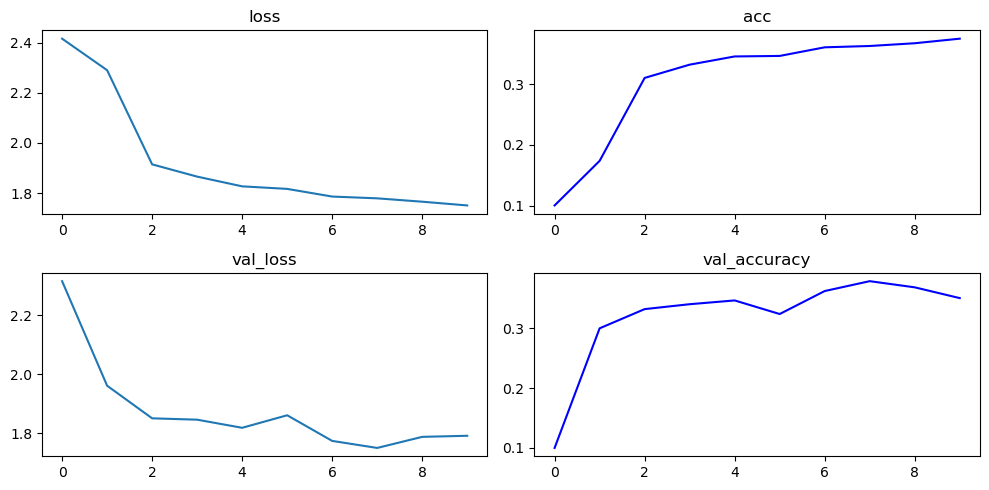

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(221)
plt.plot(hist.history['loss'])
plt.title("loss")
plt.subplot(222)
plt.plot(hist.history['accuracy'], 'b-')
plt.title("acc")
plt.subplot(223)
plt.plot(hist.history['val_loss'])
plt.title("val_loss")
plt.subplot(224)
plt.plot(hist.history['val_accuracy'], 'b-')
plt.title("val_accuracy")

plt.tight_layout()
plt.show()